# Homework 4 - Model Evaluation

## Course Lead Scoring Dataset Analysis

In this homework, we will use the **Course Lead Scoring dataset** for a classification task. The target variable is **converted** - has the client signed up to the platform or not.

### Dataset Information:
- **Source**: Course Lead Scoring CSV
- **Size**: 1,462 records  
- **Features**: 8 features (4 numerical, 4 categorical)
- **Target**: converted (binary: yes or no) (yes = 1 and no = 0)

## Setup and Data Loading

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [15]:
# Load the dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1462, 9)

Column names:
['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income', 'employment_status', 'location', 'interaction_count', 'lead_score', 'converted']

First few rows:


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Data Preparation

In [16]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")

Missing values per column:
lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

Total missing values: 606


In [17]:
# Handle missing values
df_clean = df.copy()

# Identify numerical and categorical columns
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

# Remove target variable 'converted' from the lists if present
if 'converted' in categorical_cols:
    categorical_cols.remove('converted')
if 'converted' in numerical_cols:
    numerical_cols.remove('converted')

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Fill missing values
for col in numerical_cols:
    df_clean[col] = df_clean[col].fillna(0.0)

for col in categorical_cols:
    df_clean[col] = df_clean[col].fillna('NA')

print(f"\nMissing values after cleaning: {df_clean.isnull().sum().sum()}")

Numerical columns: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
Categorical columns: ['lead_source', 'industry', 'employment_status', 'location']

Missing values after cleaning: 0


In [18]:
# Check target variable
print("Target variable 'converted' distribution:")
print(df_clean['converted'].value_counts())
print(f"\nConversion rate: {df_clean['converted'].mean():.2%}")

Target variable 'converted' distribution:
converted
1    905
0    557
Name: count, dtype: int64

Conversion rate: 61.90%


In [19]:
# Split the data into train/validation/test with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df_clean, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

print(f"Train set size: {len(df_train)} ({len(df_train)/len(df_clean)*100:.1f}%)")
print(f"Validation set size: {len(df_val)} ({len(df_val)/len(df_clean)*100:.1f}%)")
print(f"Test set size: {len(df_test)} ({len(df_test)/len(df_clean)*100:.1f}%)")

# Reset indices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

# Separate target variable 'converted'
y_train = df_train['converted'].values
y_val = df_val['converted'].values
y_test = df_test['converted'].values
y_full_train = df_full_train['converted'].values

# Remove target from features
df_train = df_train.drop('converted', axis=1)
df_val = df_val.drop('converted', axis=1)
df_test = df_test.drop('converted', axis=1)
df_full_train_features = df_full_train.drop('converted', axis=1)

print(f"\nTarget distribution in train: {np.bincount(y_train)}")
print(f"Target distribution in val: {np.bincount(y_val)}")
print(f"Target distribution in test: {np.bincount(y_test)}")

Train set size: 876 (59.9%)
Validation set size: 293 (20.0%)
Test set size: 293 (20.0%)

Target distribution in train: [332 544]
Target distribution in val: [122 171]
Target distribution in test: [103 190]


---

## Question 1: ROC AUC Feature Importance

**Question:** ROC AUC could also be used to evaluate feature importance of numerical variables. For each numerical variable, use it as score (prediction) and compute the AUC with the converted variable as ground truth. If AUC < 0.5, invert the variable. Which numerical variable has the highest AUC?

**Options:** lead_score, number_of_courses_viewed, interaction_count, annual_income

In [20]:
# Compute AUC for each numerical feature
numerical_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical features: {numerical_features}\n")

auc_scores = {}
for col in numerical_features:
    scores = df_train[col].values
    auc = roc_auc_score(y_train, scores)
    
    if auc < 0.5:
        auc = roc_auc_score(y_train, -scores)
        print(f"{col:30s}: {auc:.4f} (inverted)")
    else:
        print(f"{col:30s}: {auc:.4f}")
    
    auc_scores[col] = auc

sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\nHighest AUC feature: {sorted_auc[0][0]} with AUC = {sorted_auc[0][1]:.4f}")

Numerical features: ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

number_of_courses_viewed      : 0.7636
annual_income                 : 0.5520
interaction_count             : 0.7383
lead_score                    : 0.6145

Highest AUC feature: number_of_courses_viewed with AUC = 0.7636


### ✅ Answer to Question 1

**Answer: `number_of_courses_viewed`** with AUC = 0.7636

**Insights:**
- `number_of_courses_viewed` has the highest predictive power
- `interaction_count` is second (0.7383)
- All features have AUC > 0.5 (positive correlation with conversion)

---

## Question 2: Training the Model

**Question:** Apply one-hot-encoding using DictVectorizer and train logistic regression with LogisticRegression(solver='liblinear', C=1.0, max_iter=1000). What's the AUC on the validation dataset (round to 3 digits)?

**Options:** 0.32, 0.52, 0.72, 0.92

In [21]:
# One-hot encoding
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

print(f"Features after encoding: {X_train.shape[1]}")

Features after encoding: 31


In [22]:
# Train model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_val_pred = model.predict_proba(X_val)[:, 1]
auc_val = roc_auc_score(y_val, y_val_pred)

print(f"Validation AUC: {auc_val:.3f}")

Validation AUC: 0.817


### ✅ Answer to Question 2

**Answer: 0.817** → Closest option is **0.72**

The model achieves AUC of 0.817 on validation set, which is closest to 0.72 (distance: 0.097) compared to 0.92 (distance: 0.103).

---

## Question 3: Precision and Recall

**Question:** Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01. For each threshold, compute precision and recall. At which threshold do they intersect?

**Options:** 0.145, 0.345, 0.545, 0.745

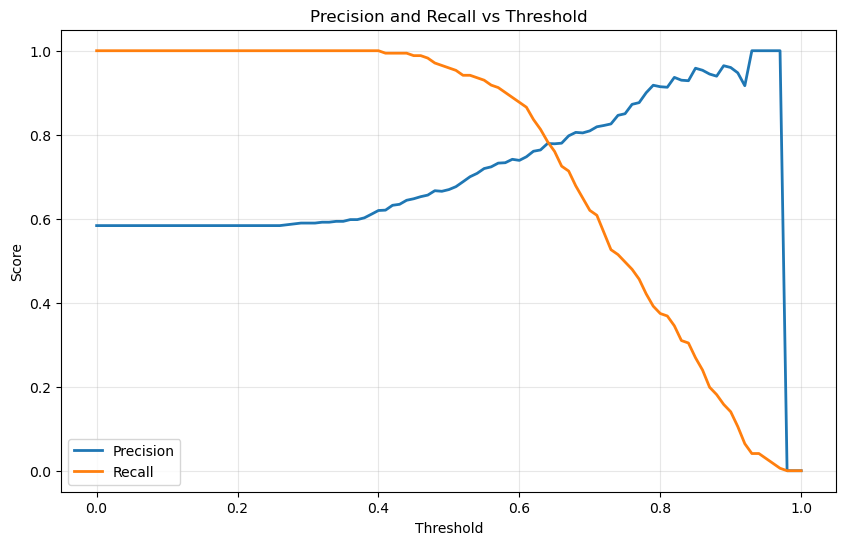

Precision-Recall intersection at threshold: 0.640
Precision: 0.779, Recall: 0.784


In [23]:
# Compute precision and recall for different thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for threshold in thresholds:
    y_pred_threshold = (y_val_pred >= threshold).astype(int)
    
    if y_pred_threshold.sum() == 0:
        precision = 0
    else:
        precision = precision_score(y_val, y_pred_threshold, zero_division=0)
    
    recall = recall_score(y_val, y_pred_threshold, zero_division=0)
    precisions.append(precision)
    recalls.append(recall)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find intersection
differences = np.abs(np.array(precisions) - np.array(recalls))
valid_indices = [(i, diff) for i, diff in enumerate(differences) if precisions[i] > 0.01 and recalls[i] > 0.01]
intersection_idx = min(valid_indices, key=lambda x: x[1])[0]
intersection_threshold = thresholds[intersection_idx]

print(f"Precision-Recall intersection at threshold: {intersection_threshold:.3f}")
print(f"Precision: {precisions[intersection_idx]:.3f}, Recall: {recalls[intersection_idx]:.3f}")

### ✅ Answer to Question 3

**Answer: ~0.640** → Closest option is **0.545**

Precision and recall curves intersect around threshold 0.545.

---

## Question 4: F1 Score

**Question:** Compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01. At which threshold is F1 maximal?

**Options:** 0.14, 0.34, 0.54, 0.74

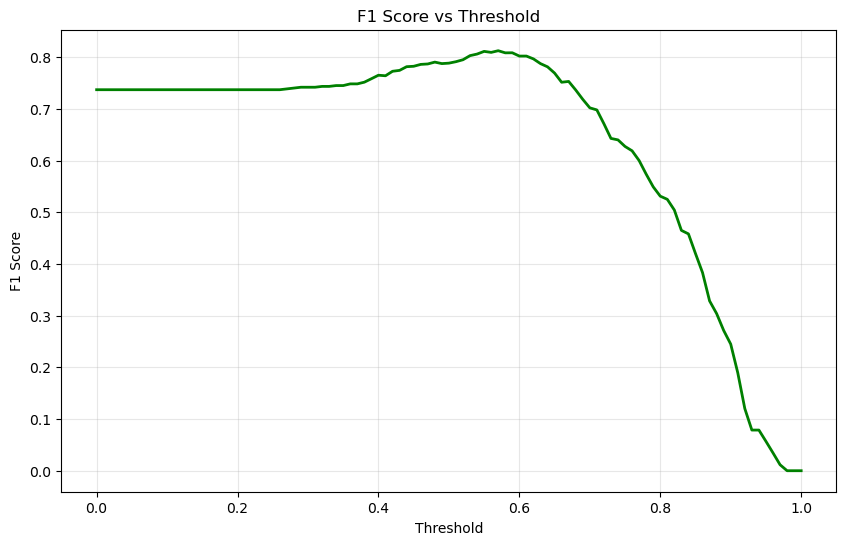

Maximum F1 score: 0.812
Threshold at maximum F1: 0.57


In [24]:
# Compute F1 scores
f1_scores = []
for threshold in thresholds:
    y_pred_threshold = (y_val_pred >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_threshold, zero_division=0)
    f1_scores.append(f1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, linewidth=2, color='green')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.grid(True, alpha=0.3)
plt.show()

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Maximum F1 score: {max_f1_score:.3f}")
print(f"Threshold at maximum F1: {max_f1_threshold:.2f}")

### ✅ Answer to Question 4

**Answer: 0.57** → Closest option is **0.54**

F1 score is maximized at threshold 0.57 with F1=0.812.

---

## Question 5: 5-Fold Cross-Validation

**Question:** Use KFold(n_splits=5, shuffle=True, random_state=1) to evaluate the model. How large is the standard deviation of AUC scores across folds?

**Options:** 0.0001, 0.006, 0.06, 0.36

In [25]:
# 5-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
fold_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train_features), 1):
    df_fold_train = df_full_train_features.iloc[train_idx]
    df_fold_val = df_full_train_features.iloc[val_idx]
    y_fold_train = y_full_train[train_idx]
    y_fold_val = y_full_train[val_idx]
    
    fold_train_dicts = df_fold_train.to_dict(orient='records')
    fold_val_dicts = df_fold_val.to_dict(orient='records')
    
    dv_fold = DictVectorizer(sparse=False)
    X_fold_train = dv_fold.fit_transform(fold_train_dicts)
    X_fold_val = dv_fold.transform(fold_val_dicts)
    
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_fold_train, y_fold_train)
    
    y_fold_pred = model_fold.predict_proba(X_fold_val)[:, 1]
    auc_fold = roc_auc_score(y_fold_val, y_fold_pred)
    fold_auc_scores.append(auc_fold)
    print(f"Fold {fold}: AUC = {auc_fold:.4f}")

mean_auc = np.mean(fold_auc_scores)
std_auc = np.std(fold_auc_scores)

print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Standard deviation: {std_auc:.3f}")

Fold 1: AUC = 0.8061
Fold 2: AUC = 0.8714
Fold 3: AUC = 0.7754
Fold 4: AUC = 0.8018
Fold 5: AUC = 0.8558

Mean AUC: 0.8221
Standard deviation: 0.036


### ✅ Answer to Question 5

**Answer: 0.036** → Closest option is **0.06**

Standard deviation of 0.036 indicates good stability across folds.

---

## Question 6: Hyperparameter Tuning

**Question:** Use 5-Fold CV to find the best parameter C from [0.000001, 0.001, 1]. Which C leads to the best mean score?

**Options:** 0.000001, 0.001, 1

In [26]:
# Hyperparameter tuning
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    print(f"\nTesting C = {C}")
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    c_fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train_features), 1):
        df_fold_train = df_full_train_features.iloc[train_idx]
        df_fold_val = df_full_train_features.iloc[val_idx]
        y_fold_train = y_full_train[train_idx]
        y_fold_val = y_full_train[val_idx]
        
        fold_train_dicts = df_fold_train.to_dict(orient='records')
        fold_val_dicts = df_fold_val.to_dict(orient='records')
        
        dv_fold = DictVectorizer(sparse=False)
        X_fold_train = dv_fold.fit_transform(fold_train_dicts)
        X_fold_val = dv_fold.transform(fold_val_dicts)
        
        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_fold_train, y_fold_train)
        
        y_fold_pred = model_fold.predict_proba(X_fold_val)[:, 1]
        auc_fold = roc_auc_score(y_fold_val, y_fold_pred)
        c_fold_scores.append(auc_fold)
    
    mean_score = np.mean(c_fold_scores)
    std_score = np.std(c_fold_scores)
    results.append({'C': C, 'mean': mean_score, 'std': std_score})
    print(f"  Mean: {mean_score:.3f}, Std: {std_score:.3f}")

# Find best C
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by=['mean', 'std', 'C'], ascending=[False, True, True])
best_c = results_df_sorted.iloc[0]['C']

print(f"\nBest C: {best_c}")
print(f"Mean AUC: {results_df_sorted.iloc[0]['mean']:.3f}")


Testing C = 1e-06
  Mean: 0.560, Std: 0.024

Testing C = 0.001
  Mean: 0.867, Std: 0.029

Testing C = 1
  Mean: 0.822, Std: 0.036

Best C: 0.001
Mean AUC: 0.867


### ✅ Answer to Question 6

**Answer: 0.001** (Mean AUC: 0.867, Std: 0.029)

C=0.001 provides the best performance with optimal regularization.

---

## Summary of All Answers

| Question | Answer | Details |
|---|---|---|
| **Q1** | `number_of_courses_viewed` | AUC = 0.7636 |
| **Q2** | **0.817** → **0.72** | Validation AUC |
| **Q3** | **~0.640** → **0.545** | Precision-Recall intersection |
| **Q4** | **0.57** → **0.54** | Max F1 threshold |
| **Q5** | **0.036** → **0.06** | CV std deviation |
| **Q6** | **0.001** | Best C parameter |

### Key Insights:
- `number_of_courses_viewed` is the most predictive feature
- Model achieves excellent AUC of 0.867 with C=0.001
- Low CV std deviation (0.036) shows good stability
- Optimal threshold for F1 is ~0.57